In [1]:
%load_ext autoreload
%autoreload 2

# Training as a function of the number of patterns

In [2]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from wassa.wassa_plots import plot_results_std, plot_SM, plot_colored_raster
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_utils import train_and_plot

In [3]:
def performance_as_a_function_of_number_of_motifs(world_parameters, training_parameters, date, num_patterns, N_iter = 5, seeds = None, device='cpu'):
    
    freq_init = world_parameters.freq_sms[0]
    
    results = torch.zeros([3,N_iter,len(num_patterns),6])
    if seeds is not None:
        assert seeds.size(0)==N_iter
    else:
        seeds = torch.randint(1000,[N_iter])
    
    params_mse = training_parameters()
    params_emd = training_parameters()
    params_emd.loss_type = 'emd'
    params_emd.penalty_type = 'kernels_orthogonality'
    params_emd.lambda_ = .0014
    file_name = f'results/{date}_performance_as_a_function_of_number_of_motifs_{world_parameters.get_parameters()}_{params_mse.get_parameters()}_{num_patterns[0]}_{num_patterns[-1]}'
    print(file_name)
    
    if os.path.isfile(file_name):
        results, num_patterns = torch.load(file_name, map_location='cpu')
    else:
        pbar = tqdm(total=len(num_patterns)*N_iter)
        for i in range(N_iter):
            world_parameters.seed = seeds[i]
            for ind_f, n_mot in enumerate(num_patterns):
                world_parameters.N_SMs = n_mot
                world_parameters.N_involved = world_parameters.N_pre*torch.ones(n_mot)
                world_parameters.freq_sms = freq_init.div(n_mot)*torch.ones(n_mot)
                params_emd.kernel_size = (n_mot,world_parameters.N_pre,world_parameters.N_delays)
                params_mse.kernel_size = (n_mot,world_parameters.N_pre,world_parameters.N_delays)
                sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters,verbose = False,device=device)
                results[0,i,ind_f,0], results[0,i,ind_f,1], results[0,i,ind_f,2], results[0,i,ind_f,3], results[0,i,ind_f,4], results[0,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_mse], date, iteration = i, device=device)
                results[1,i,ind_f,0], results[1,i,ind_f,1], results[1,i,ind_f,2], results[1,i,ind_f,3], results[1,i,ind_f,4], results[1,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_emd], date, iteration = i, device=device)
                results[2,i,ind_f,0], results[2,i,ind_f,1], results[2,i,ind_f,2], results[2,i,ind_f,3], results[2,i,ind_f,4], results[2,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_emd,params_mse], date, iteration = i, device=device)
                pbar.update(1)

        pbar.close()
        torch.save([results, num_patterns], file_name)
    return results, num_patterns

In [4]:
date = '2024_01_15'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

In [6]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 255 # number of timesteps for the raster plot (in ms)
    N_samples = 100 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 16*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

## Generative model

Usually I create a $NxD$ kernel to generate spiking motifs. On this kernel (below), probabilities of having a spike are given for each pixel corresponding to a specific adress and a specific delay. 

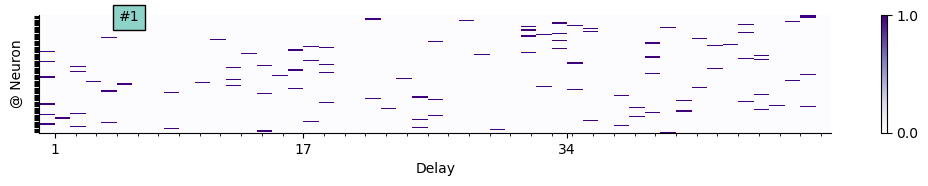

In [7]:
world_parameters = dataset_parameters();
sm = sm_generative_model(world_parameters, device = device)
plot_SM(sm.SMs);

Then, I generate trials (equivalent to a recording session) with a duration length ($T$) that can be longer than than the length of the kernel ($D$). There is a frequency of occurence given for the different motifs. See below with $T=10\cdot D=510\;ms$ and frequency of apparition is $6\;Hz$. The motif occurs 2 times and then a totally flat probability distribution represents backgroun activity. Spikes are obtained with Bernoulli trials on each time points of the matric $NxT$ of probability values.

../synthetic_data/synthetic_rp_trainset_50_100_51_1_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666.pt
../synthetic_data/synthetic_rp_testset_50_100_51_1_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666.pt


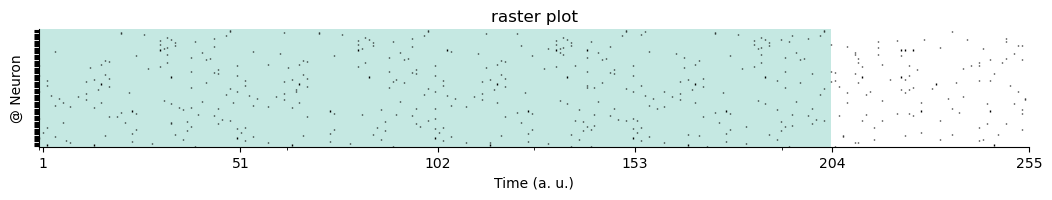

In [8]:
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters, device=device)
random_ind = torch.randint(testset_input.shape[0],[1])
fig_raster, ax_raster = plot_colored_raster(testset_input[random_ind], testset_output[random_ind].cpu().numpy(), world_parameters.N_delays);

In [9]:
class training_parameters:
    kernel_size = (sm.opt.N_SMs, sm.opt.N_pre, sm.opt.N_delays)
    loss_type = 'mse'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = 'smoothed_orthogonality'
    smoothwind = 40
    lambda_ = .014
    batch_size = None
    output = 'linear' 
    do_bias = True 
    zeros = 'ignore'
    wass_order = 1
    weight_init = None
    if not penalty_type: 
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed': 
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd':
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [ ]:
N_iter = 10
seeds = torch.arange(0,N_iter)
num_patterns = torch.arange(1,10)
results, num_patterns = performance_as_a_function_of_number_of_motifs(world_parameters, training_parameters, date, num_patterns, N_iter = N_iter, seeds = seeds, device=device)

results/2024_01_15_performance_as_a_function_of_number_of_motifs_100_51_1_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_mse_linear_smoothed_orthogonality_True_(1, 100, 51)_1000_0.001_0.014_None_40_1_9


/home/antoineg/wassa/wassa/wassa_utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path + '.pth', map_location=torch.device(device)

In [ ]:
def plot_results_std(ax, results, coefs, xlabel, ylabel, legend, color, do_ylabel, ymax=None, ymin=None, do_legend=False, logplot=False, quantile=False):
     
    mean_, std_ = results.mean(axis=0), results.std(axis=0)
    
    if quantile: 
        q5 = results.quantile(.1,axis=0)
        q95 = results.quantile(.9,axis=0)

    if quantile:
        bottom_ = q5
    elif ymin is not None:
        bottom_ = np.maximum(mean_ - std_, ymin*np.ones([len(mean_)]))
    else:
        bottom_ = mean_ - std_
        
    if quantile:
        top_ = q95
    elif ymax is not None:
        top_= np.minimum(mean_ + std_, ymax*np.ones([len(mean_)]))
    else:
        top_ = mean_ + std_

    if logplot:
        ax.semilogx(coefs, mean_, '.',color=color, label=legend)
    else:
        ax.plot(coefs, mean_, '.',color=color, label=legend)
    ax.fill_between(coefs, bottom_, top_, facecolor=color, edgecolor=None, alpha=.3)

    ax.set_ylim(ymin,ymax)
    
    if xlabel: 
        ax.set_xlabel(xlabel, fontsize=14)
    else: 
        ax.set_xticks([])
    if do_ylabel:
        ax.set_ylabel('similarity valuseu jorge albume', fontsize=14)
    else: 
        ax.set_yticks([])
    ax.set_title(ylabel, fontsize=16)
    if do_legend: 
        ax.legend(fontsize=12);

    return ax

In [ ]:
import matplotlib.pyplot as plt

name_metrics = ['factors similarity', 'kernels similarity', 'mean timings similarity']
name_methods = ['MSE', 'EMD', 'combined']
colors = ['darkolivegreen','blue','orangered']
xlabel = '# spiking motifs'

results = results.cpu()
fig, ax = plt.subplots(1,3, figsize=(16,5))
for i in range(len(name_metrics)):
    for m in range(len(name_methods)):
        if i==0:
            do_ylabel = True
        else:
            do_ylabel = False
        ax[i] = plot_results_std(ax[i],results[m,:,:,i],num_patterns,xlabel,name_metrics[i],name_methods[m],colors[m],ymax=1,ymin=0,do_ylabel=do_ylabel,quantile=True)